# Group 6: Algorithmic Trading Signals

## Moving Average Convergence Divergence: Ed Foote

In [110]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import pandas_datareader as pdr
import hvplot.pandas
import matplotlib.pyplot as plt
import pyEX as p
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pandas.tseries.offsets import DateOffset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [111]:
# Select start and end dates
start_date = pd.Timestamp('2016-10-12', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-10-12', tz='America/New_York').isoformat()



In [112]:
# Import the Yahoo Finance dataset into a Pandas Dataframe, in this case JP Morgan.
# We only need the date and the adjusted closing price. 
jpm_df = pdr.DataReader('JPM','yahoo',start_date,end_date)['Adj Close']


jpm_df.tail()

Date
2021-10-06    169.020004
2021-10-07    170.089996
2021-10-08    170.220001
2021-10-11    166.639999
2021-10-12    165.360001
Name: Adj Close, dtype: float64

In [113]:
# Make the MACD and the signal line
exp1 = jpm_df.ewm(span=12, adjust=False).mean()
exp2 = jpm_df.ewm(span=26, adjust=False).mean()
macd = exp1 - exp2

exp3 = macd.ewm(span=9, adjust=False).mean()

In [114]:
#Change column names 
macd.head()
macd.rename("MACD")

Date
2016-10-12    0.000000
2016-10-13   -0.027144
2016-10-14   -0.063412
2016-10-17   -0.115464
2016-10-18   -0.118042
                ...   
2021-10-06    2.872744
2021-10-07    3.132948
2021-10-08    3.311480
2021-10-11    3.128033
2021-10-12    2.846551
Name: MACD, Length: 1259, dtype: float64

In [115]:
exp3.rename("Signal")

Date
2016-10-12    0.000000
2016-10-13   -0.005429
2016-10-14   -0.017025
2016-10-17   -0.036713
2016-10-18   -0.052979
                ...   
2021-10-06    1.895447
2021-10-07    2.142947
2021-10-08    2.376654
2021-10-11    2.526929
2021-10-12    2.590854
Name: Signal, Length: 1259, dtype: float64

<AxesSubplot:>

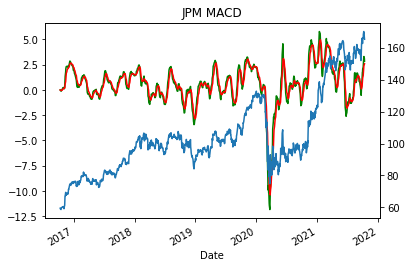

In [144]:
# Plot

macd.plot(label='JPM MACD', color='g', title = 'JPM MACD')
ax = exp3.plot(label='Signal Line', color='r')
jpm_df.plot(ax=ax, secondary_y=True, label='')

In [117]:
jpm = pd.concat([jpm_df,macd,exp3], axis=1)

jpm.columns = ['Adj Close', 'MACD', 'Signal Line']

jpm.head()

,Adj Close,MACD,Signal Line
Date,,,
2016-10-12,59.441154,0.000000,0.000000
2016-10-13,59.100887,-0.027144,-0.005429
2016-10-14,58.908955,-0.063412,-0.017025
2016-10-17,58.603592,-0.115464,-0.036713
2016-10-18,59.065998,-0.118042,-0.052979


## Create the model


In [118]:
#Add a trade type column to the dataframe

jpm['trade type'] = np.nan
jpm['trade type'] = jpm['trade type'].astype(str)
jpm.head()

,Adj Close,MACD,Signal Line,trade type
Date,,,,
2016-10-12,59.441154,0.000000,0.000000,nan
2016-10-13,59.100887,-0.027144,-0.005429,nan
2016-10-14,58.908955,-0.063412,-0.017025,nan
2016-10-17,58.603592,-0.115464,-0.036713,nan
2016-10-18,59.065998,-0.118042,-0.052979,nan


In [119]:

jpm.drop(['trade_type'], axis=1)

KeyError: "['trade_type'] not found in axis"

In [120]:
#Trading strategy, buy when the MACD signal line moves from negative. Sell vice versa.

jpm['lag'] = np.nan
jpm.head()

jpm.drop(['trade_type'], axis=1)

KeyError: "['trade_type'] not found in axis"

In [121]:
jpm['lag'] = jpm['Signal Line'].shift()

In [122]:
jpm['signal'] = np.nan

In [123]:
for index, row in jpm.iterrows():
    if row['Signal Line'] > 0 and row['lag'] < 0:
        jpm.at[index,'trade type'] = 'Buy'
    elif row['Signal Line']<0 and row['lag']>0:
        jpm.at[index,'trade type'] = 'Sell'
    

In [124]:
jpm.head(40)

,Adj Close,MACD,Signal Line,trade type,lag,signal
Date,,,,,,
2016-10-12,59.441154,0.000000,0.000000,nan,NaN,NaN
2016-10-13,59.100887,-0.027144,-0.005429,nan,0.000000,NaN
2016-10-14,58.908955,-0.063412,-0.017025,nan,-0.005429,NaN
2016-10-17,58.603592,-0.115464,-0.036713,nan,-0.017025,NaN
2016-10-18,59.065998,-0.118042,-0.052979,nan,-0.036713,NaN
2016-10-19,59.633102,-0.073478,-0.057079,nan,-0.052979,NaN
2016-10-20,59.554577,-0.043990,-0.054461,nan,-0.057079,NaN
2016-10-21,59.755245,-0.004378,-0.044444,nan,-0.054461,NaN
2016-10-24,60.086788,0.053155,-0.024924,nan,-0.044444,NaN


In [125]:
jpm.tail()

,Adj Close,MACD,Signal Line,trade type,lag,signal
Date,,,,,,
2021-10-06,169.020004,2.872744,1.895447,nan,1.651123,NaN
2021-10-07,170.089996,3.132948,2.142947,nan,1.895447,NaN
2021-10-08,170.220001,3.311480,2.376654,nan,2.142947,NaN
2021-10-11,166.639999,3.128033,2.526929,nan,2.376654,NaN
2021-10-12,165.360001,2.846551,2.590854,nan,2.526929,NaN


In [126]:
jpm['trade type'].value_counts()

nan     1230
Buy       15
Sell      14
Name: trade type, dtype: int64

In [127]:
#Alternative method for scaling and training ect.

#Extra factor variables # X = jpm[['Adj Close', 'MACD','Signal Line', 'lag']].shift().dropna().copy()

# X = jpm[['Signal Line', 'lag']].shift().dropna().copy()

X = jpm[['Signal Line']].shift().dropna().copy()

jpm['signal'] = 0
jpm.loc[(jpm['trade type'] == 'Buy'), 'signal'] = 1
jpm.loc[(jpm['trade type'] == 'Sell'), 'signal'] = -1


y = jpm['signal'].copy()

# Select the start of the training period
training_begin = X.index.min()

# Select the ending period for the training data with an offset of one year 
training_end = X.index.min() + DateOffset(years=1)



In [128]:
y.value_counts()


 0    1230
 1      15
-1      14
Name: signal, dtype: int64

In [129]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
X_train.head()

,Signal Line
Date,
2016-10-13,0.000000
2016-10-14,-0.005429
2016-10-17,-0.017025
2016-10-18,-0.036713
2016-10-19,-0.052979


In [130]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
X_test.head()

,Signal Line
Date,
2017-10-13,1.213860
2017-10-16,1.202797
2017-10-17,1.204633
2017-10-18,1.208579
2017-10-19,1.216156


In [131]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X_train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [132]:
y_train.value_counts()

 0    248
 1      3
-1      2
Name: signal, dtype: int64

In [133]:

# Create the classifier model
svm_model = svm.SVC()

# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [134]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         2
           0       0.98      1.00      0.99       248
           1       0.00      0.00      0.00         3

    accuracy                           0.98       253
   macro avg       0.33      0.33      0.33       253
weighted avg       0.96      0.98      0.97       253



/Users/edwardfoote/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/edwardfoote/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/edwardfoote/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic Regression

In [135]:
# Split training and testing sets
# Create X, or features DataFrame
features = jpm[['Signal Line']]

# Create y, or target DataFrame
target = jpm['signal']

# Use train_test_split to separate the data
training_features, testing_features, training_targets, testing_targets = train_test_split(features, target)

In [136]:
logistic_regression_model = LogisticRegression()

In [137]:
# Fit the model
logistic_regression_model.fit(training_features, training_targets)

LogisticRegression()

In [138]:
# Generate predictions from the model we just fit
predictions = logistic_regression_model.predict(training_features)

# Convert those predictions (and actual values) to a DataFrame
results_df = pd.DataFrame({"Prediction": predictions, "Actual": training_targets})
results_df

,Prediction,Actual
Date,,
2020-07-09,0,0
2020-02-11,0,0
2020-03-09,0,0
2018-02-20,0,0
2018-06-18,0,0
...,...,...
2017-06-22,0,0
2021-10-01,0,0
2021-01-12,0,0


In [139]:
# Apply the fitted model to the test dataset
testing_predictions = logistic_regression_model.predict(testing_features)

# Save both the test predictions and actual test values to a DataFrame
results_df = pd.DataFrame({
    "Testing Data Predictions": testing_predictions,
    "Testing Data Actual Targets": testing_targets})
results_df

,Testing Data Predictions,Testing Data Actual Targets
Date,,
2018-11-02,0,0
2016-10-12,0,0
2019-02-19,0,0
2018-05-14,0,0
2017-03-29,0,-1
...,...,...
2019-11-18,0,0
2020-06-04,0,0
2018-08-20,0,0


In [140]:
# Calculate the model's accuracy on the test dataset
accuracy_score(testing_targets, testing_predictions)

0.9682539682539683

In [141]:
#Generate training predictions
training_predictions = logistic_regression_model.predict(training_features)

#Generate testing predictions
testing_predictions = logistic_regression_model.predict(testing_features)

In [142]:
#Print the confusion matrix
training_matrix = confusion_matrix(training_targets, training_predictions)
print(training_matrix)

[[  0   7   0]
 [  0 925   0]
 [  0  12   0]]


In [143]:
# Save a classification report
training_report = classification_report(training_targets, training_predictions)
# Then view its output
print(training_report)

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         7
           0       0.98      1.00      0.99       925
           1       0.00      0.00      0.00        12

    accuracy                           0.98       944
   macro avg       0.33      0.33      0.33       944
weighted avg       0.96      0.98      0.97       944



/Users/edwardfoote/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/edwardfoote/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/edwardfoote/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Simple Moving Average: Malaku Malaku 

In [67]:
# Import the necessary libraries and dependecies
import pandas as pd
import yfinance as yf
import numpy as np
import hvplot.pandas
import matplotlib.pyplot as plt 
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.linear_model import LogisticRegression



In [68]:
# Download the stock information from yahoo finance
jpm = yf.download('JPM', start='2016-10-12')

[*********************100%***********************]  1 of 1 completed


In [69]:
# Creat function to calculate SMA
def sma(data, n):
    sma = data.rolling(window = n).mean()
    return pd.DataFrame(sma)

n = [50, 200]
for i in n:
    jpm[f'sma_{i}'] = sma(jpm['Close'], i)
    
jpm.tail()

,Open,High,Low,Close,Adj Close,Volume,sma_50,sma_200
Date,,,,,,,,
2021-10-25,172.710007,172.960007,170.479996,170.940002,170.940002,10159200,162.1578,154.51215
2021-10-26,171.000000,172.490005,170.539993,171.399994,171.399994,8015100,162.4072,154.67890
2021-10-27,170.320007,170.699997,167.339996,167.830002,167.830002,9847000,162.6236,154.81695
2021-10-28,168.300003,170.509995,167.960007,170.360001,170.360001,7212900,162.9192,154.96700
2021-10-29,171.179993,172.240005,169.389999,169.889999,169.889999,8139500,163.2314,155.11060


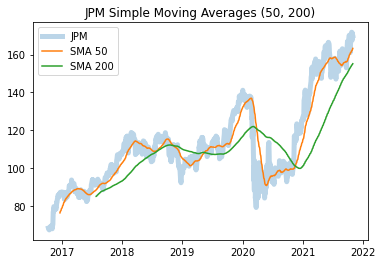

In [70]:
# Visualize the closing price and the sma
plt.plot(jpm['Close'], label = 'JPM', linewidth = 5, alpha = 0.3)
plt.plot(jpm['sma_50'], label = 'SMA 50')
plt.plot(jpm['sma_200'], label = 'SMA 200')
plt.title('JPM Simple Moving Averages (50, 200)')
plt.legend(loc = 'upper left')
plt.show()

In [71]:
# Creat a strategy function.
def sma_strategy(data, short_window, long_window):
    sma1 = short_window
    sma2 = long_window
    buy_price = []
    sell_price = []
    sma_signal = []
    signal = 0
    
    for i in range(len(data)):
        if sma1[i] > sma2[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                sma_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                sma_signal.append(0)
        elif sma2[i] > sma1[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                sma_signal.append(-1)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                sma_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            sma_signal.append(0)
            
    return buy_price, sell_price, sma_signal

sma_50 = jpm['sma_50']
sma_200 = jpm['sma_200']

buy_price, sell_price, signal = sma_strategy(jpm['Close'], sma_50, sma_200)

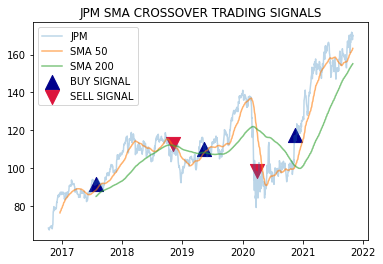

In [72]:
# Plot the SMA values along with the buy and sell signals generated by the strategy function.
plt.plot(jpm['Close'], alpha = 0.3, label = 'JPM')
plt.plot(sma_50, alpha = 0.6, label = 'SMA 50')
plt.plot(sma_200, alpha = 0.6, label = 'SMA 200')
plt.scatter(jpm.index, buy_price, marker = '^', s = 200, color = 'darkblue', label = 'BUY SIGNAL')
plt.scatter(jpm.index, sell_price, marker = 'v', s = 200, color = 'crimson', label = 'SELL SIGNAL')
plt.legend(loc = 'upper left')
plt.title('JPM SMA CROSSOVER TRADING SIGNALS')
plt.show()

In [73]:
# Calculate the daily returns using the closing prices and the pct_change function
jpm["actual_returns"] = jpm["Close"].pct_change().dropna()

# Display sample data
display(jpm.head())
display(jpm.tail())

,Open,High,Low,Close,Adj Close,Volume,sma_50,sma_200,actual_returns
Date,,,,,,,,,
2016-10-12,68.260002,68.589996,68.050003,68.129997,59.441151,11899800,NaN,NaN,NaN
2016-10-13,67.459999,67.870003,66.820000,67.739998,59.100895,17890000,NaN,NaN,-0.005724
2016-10-14,68.800003,69.029999,67.300003,67.519997,58.908951,24163800,NaN,NaN,-0.003248
2016-10-17,67.419998,67.790001,66.739998,67.169998,58.603588,14963400,NaN,NaN,-0.005184
2016-10-18,67.849998,68.209999,67.540001,67.699997,59.066006,11870300,NaN,NaN,0.007890


,Open,High,Low,Close,Adj Close,Volume,sma_50,sma_200,actual_returns
Date,,,,,,,,,
2021-10-25,172.710007,172.960007,170.479996,170.940002,170.940002,10159200,162.1578,154.51215,-0.004890
2021-10-26,171.000000,172.490005,170.539993,171.399994,171.399994,8015100,162.4072,154.67890,0.002691
2021-10-27,170.320007,170.699997,167.339996,167.830002,167.830002,9847000,162.6236,154.81695,-0.020828
2021-10-28,168.300003,170.509995,167.960007,170.360001,170.360001,7212900,162.9192,154.96700,0.015075
2021-10-29,171.179993,172.240005,169.389999,169.889999,169.889999,8139500,163.2314,155.11060,-0.002759


In [74]:
# Assign a copy of the sma_50 and sma_200 columns to a new DataFrame called X.
X = jpm[['sma_50', 'sma_200']].shift().dropna().copy()

# Display sample data
display(X.head())
display(X.tail())

,sma_50,sma_200
Date,,
2017-07-31,88.3882,84.94095
2017-08-01,88.5450,85.05930
2017-08-02,88.7100,85.18575
2017-08-03,88.8782,85.31370
2017-08-04,89.0130,85.44035


,sma_50,sma_200
Date,,
2021-10-25,161.9386,154.33755
2021-10-26,162.1578,154.51215
2021-10-27,162.4072,154.67890
2021-10-28,162.6236,154.81695
2021-10-29,162.9192,154.96700


In [75]:
# Create a new signal column
jpm['signal'] = 0.0

In [76]:
# Create a signal to buy and sell
jpm.loc[(jpm['actual_returns'] >= 0), 'signal'] = 1

jpm.loc[(jpm['actual_returns'] < 0), 'signal'] = -1

In [77]:
# Copy the new signal column to y.
y = jpm['signal'].copy()
y.value_counts()

 1.0    658
-1.0    613
 0.0      1
Name: signal, dtype: int64

In [78]:
# Set the training starting date.
training_begin = X.index.min()
print(training_begin)

2017-07-31 00:00:00


In [79]:
# Set the training end date.
training_end = X.index.min() + DateOffset(years=1)
print(training_end)

2018-07-31 00:00:00


In [80]:
# X_train and y_train DataFrames( create the training datasets)
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

X_train.head()

,sma_50,sma_200
Date,,
2017-07-31,88.3882,84.94095
2017-08-01,88.5450,85.05930
2017-08-02,88.7100,85.18575
2017-08-03,88.8782,85.31370
2017-08-04,89.0130,85.44035


In [81]:
# X_test and y_test DataFrames( create the testing datasets)
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

X_test.head()

,sma_50,sma_200
Date,,
2018-07-31,108.9686,108.62790
2018-08-01,109.0450,108.72270
2018-08-02,109.1152,108.82170
2018-08-03,109.1780,108.91325
2018-08-06,109.2700,109.01060


In [82]:
# StandardScaler instance
scaler = StandardScaler()

In [83]:
# The scaler model to fit the X_train data
X_scaler = scaler.fit(X_train)

In [84]:
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [85]:
# Classifier model
svm_model = svm.SVC()
 
# Fit the model
svm_model = svm_model.fit(X_train_scaled, y_train)

# Used the trained model to predict the trading signals for the training data.
training_signal_predictions = svm_model.predict(X_train_scaled)

# Sample predictions
training_signal_predictions[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [86]:
# Classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.52      0.42      0.46       120
         1.0       0.55      0.65      0.60       133

    accuracy                           0.54       253
   macro avg       0.53      0.53      0.53       253
weighted avg       0.53      0.54      0.53       253



In [87]:
# Used the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [88]:
# Evaluating the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.49      0.36      0.42       400
         1.0       0.51      0.64      0.57       420

    accuracy                           0.50       820
   macro avg       0.50      0.50      0.49       820
weighted avg       0.50      0.50      0.49       820



In [89]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["predicted_signal"] = testing_signal_predictions
predictions_df["actual_returns"] = jpm["actual_returns"]
predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
Date,,,
2018-07-31,-1.0,-0.015249,0.015249
2018-08-01,-1.0,0.006177,-0.006177
2018-08-02,-1.0,0.004237,-0.004237
2018-08-03,-1.0,0.008093,-0.008093
2018-08-06,-1.0,0.000256,-0.000256


<AxesSubplot:xlabel='Date'>

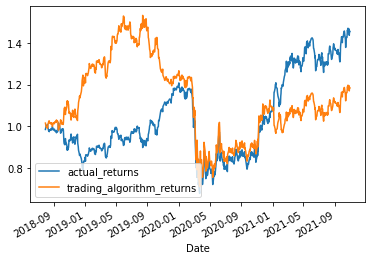

In [90]:
# The cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

In [91]:
# Create an instance of the LogisticRegression model
logistic_regression_model = LogisticRegression()

In [92]:
# Fit the LogisticRegression model
logistic_regression_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [93]:
# Use the trained LogisticRegression model to predict the trading signals for the training data
lr_training_signal_predictions = logistic_regression_model.predict(X_train_scaled)

# Diplay the predictions
lr_training_signal_predictions[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [94]:
# Generate a classification report using the training data and the logistic regression model's predications
lr_training_report = classification_report(y_train, lr_training_signal_predictions)

# Review the classification report
print(lr_training_report)

              precision    recall  f1-score   support

        -1.0       0.53      0.24      0.33       120
         1.0       0.54      0.80      0.65       133

    accuracy                           0.54       253
   macro avg       0.53      0.52      0.49       253
weighted avg       0.53      0.54      0.50       253



In [95]:
# Use the trained model to predict the trading signals for the testing data.
lr_testing_signal_predictions = logistic_regression_model.predict(X_test_scaled)

In [96]:
# Generate a classification report using the testing data and the logistic regression model's predictions
lr_testing_report = classification_report(y_test, lr_testing_signal_predictions)

# Review the testing classification report
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       0.49      0.90      0.63       400
         1.0       0.53      0.11      0.19       420

    accuracy                           0.50       820
   macro avg       0.51      0.50      0.41       820
weighted avg       0.51      0.50      0.41       820



In [97]:
# Classification report for the SVM model using the test data
print("SVM Classification Report")
print(svm_testing_report)

SVM Classification Report
              precision    recall  f1-score   support

        -1.0       0.49      0.36      0.42       400
         1.0       0.51      0.64      0.57       420

    accuracy                           0.50       820
   macro avg       0.50      0.50      0.49       820
weighted avg       0.50      0.50      0.49       820



In [98]:
# Classification report for the Logistic Regression model using the test data
print("Logistic Regression Classification Report")
print(lr_testing_report)

Logistic Regression Classification Report
              precision    recall  f1-score   support

        -1.0       0.49      0.90      0.63       400
         1.0       0.53      0.11      0.19       420

    accuracy                           0.50       820
   macro avg       0.51      0.50      0.41       820
weighted avg       0.51      0.50      0.41       820

